In [986]:
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import pymongo
from PIL import Image
import h5py
import io
import json
import scipy
import requests
from collections import Counter
import mediapy as media 
import tqdm.notebook as tqdm
import seaborn as sns
import colormap

In [953]:
CONN = pymongo.MongoClient("mongodb://localhost:27017/")
DB = CONN["mlve_results"]["results"]
results_df = pd.DataFrame(list(DB.find()))
S3_root = "https://mlve-v1.s3.us-east-2.amazonaws.com/"

In [954]:
def points_in_circle(radius, x0=0, y0=0, n_points=100, uniform=False, max_loc=511, min_loc=0):
    """
    returns points in a circle with a given radius, centered at x0, y0
    """
    theta = np.linspace(0, 2*np.pi, n_points)
    a, b = 1 * np.cos(theta), 1 * np.sin(theta)
    r = np.random.rand((n_points))
    if uniform:
        # Balances the density of points in the circle
        r = np.sqrt(r)

    x, y = r * np.cos(theta), r * np.sin(theta)
    xpoints, ypoints = x * radius + x0, y * radius + y0
    xpoints = np.clip(xpoints, min_loc, max_loc)
    ypoints = np.clip(ypoints, min_loc, max_loc)
    return xpoints, ypoints


def normal_to_rgb(normal):
    normal = ((normal + 1) * 0.5) * 255
    normal = np.clip(normal, 0, 255) / 255
    return normal

In [1008]:

def load_model_prediction(task, dataset, model, image_id, results_dir="/Users/yonifriedman/Projects/mlve/results/model_predictions/", resize=None):
    """
        Loads model prediction for a given image/task/dataset combination
    """
    if model == "EISEN":
        extension = ".npy"
    else:
        extension = ".png"
        
    if task == "surface-normals":
        task = "normals"
        extension = ".hdf5"
        
    images_path = os.path.join(results_dir, task, model, dataset, "*" + extension)
    images = glob(images_path)
    images.sort()
    image_path = images[image_id]
    if extension == ".png":
        img = Image.open(image_path)
        if task == "segmentation":
            img = img.convert("L")
            if resize is not None:
                img = img.resize(resize, Image.Resampling.NEAREST)
            img = colormap.remap_labels(np.array(img))
                
        else:
            img = np.array(img)
    elif extension == ".hdf5":
        img = h5py.File(image_path, "r")["dataset"][:]
    elif extension == ".npy":
        img = np.load(image_path)
        
    if "AlleatoricNormals" in model:
        img = normal_to_rgb(img).astype(np.float32)
        x = img[:, :, 0] 
        y = img[:, :, 1]
        z = img[:, :, 2]
        img = np.stack([1 - x, y, z ]).transpose(1, 2, 0) 


    return img


In [956]:

def trunc(values, decs=3):
    return np.trunc(values*10**decs)/(10**decs)

def image_from_url(url, extension=".hdf5", convert=False):
    try:
        response = requests.get(url)
    except Exception as e:
        return None
    
    if response.status_code != 200:
        return None
        
    if extension == ".hdf5":
        img = h5py.File(io.BytesIO(response.content), "r")["dataset"][:]
    else:
        img = Image.open(io.BytesIO(response.content))

    if convert:
        img = img.convert("L")
        
    return np.array(img)


def get_input_img(task, dataset, image_id):
    url = f"https://mlve-v1.s3.us-east-2.amazonaws.com/{dataset}/images/image_{image_id:03d}.png"
    img = image_from_url(url, extension=".png")
    return img

def get_ground_truth(task, dataset, image_id):
    if task == "depth":
        extension = ".hdf5"
        gt_url = f"https://mlve-v1.s3.us-east-2.amazonaws.com/{dataset}/depths/depth_{image_id:03d}" + extension
    elif task == "segmentation":
        extension = ".png"
        gt_url = f"https://mlve-v1.s3.us-east-2.amazonaws.com/{dataset}/masks/mask_{image_id:03d}" + extension
    elif task == "surface-normals":
        extension = ".hdf5"
        gt_url = f"https://mlve-v1.s3.us-east-2.amazonaws.com/{dataset}/normals/normal_{image_id:03d}" + extension
    
    
    root_path = "/Users/yonifriedman/Projects/mlve/stimuli/data/"
    image_path = os.path.join(root_path, gt_url.split(".com/")[1])
    if os.path.exists(image_path):
        if extension == ".hdf5":
            gt = np.array(h5py.File(image_path, "r")["dataset"][:])
        else:
            gt = Image.open(image_path)
            if task == "segmentation":
                gt = np.array(gt.convert("L"))
                gt = colormap.remap_labels(gt)
            else:
                gt = np.array(gt)
    else:
        return None
        
    #gt = image_from_url(gt_url, extension=extension)

    return gt


def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

    
def angular_dist(v1, v2, use_degrees=True):
    """ Returns the angle in radians between vectors 'v1' and 'v2':
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)

    radians = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    degrees = np.degrees(radians)
    if not use_degrees:
        return radians
    else:
        return degrees

In [957]:
# rescore depth results -- if someone answered "same" and probes are within some delta of depth mark them as correct
def rescore_depth(df):
    depth_resps = df[df["experiment_type"] == "depth"]
    gts = []
    count = 0
    for i, resp in df.iterrows():
        if resp["experiment_type"] == "depth" and resp["response"] == 2 and resp["score"] == 0 and resp["gt"] is not None:
            gt = resp["gt"]
            if np.abs(gt[0] - gt[1]) < 0.01:
                count += 1
                df.at[i, "score"] = 1
    print(f"Updated {count} responses")
    return df

# results_df2 = rescore_depth(results_df)

In [958]:

def get_human_responses(task, dataset, image_id, df):
    """ 
        Loads human responses for a given image/task/dataset combination
        from dataframe of behavioral results
    """
    S3_root = "https://mlve-v1.s3.us-east-2.amazonaws.com/"
    trials = df[(df["experiment_type"] == task) & (df["imageURL"] == os.path.join(S3_root, dataset, "images", f"image_{image_id:03d}.png"))]
    gt = get_ground_truth(task, dataset, image_id)

    responses = {}
    for i, row in trials.iterrows():
        batchID = int(row["batchID"])
        if batchID not in responses:
            responses[batchID] = {"probeLocation": row["probeLocation"], "responses": [], "url": row["imageURL"], "score": []}
        
        resp = row["response"]
        if task == "depth":
            resp = int(resp)
            if resp == 2:
                continue

            probe_location = row["probeLocation"]

            if gt is not None:
                gt_left = gt[probe_location[0][1], probe_location[0][0]]
                gt_right = gt[probe_location[1][0], probe_location[1][1]]
                if gt_left == gt_right:
                    continue
                
                if (gt_left < gt_right and resp == 0) or (gt_left > gt_right and resp == 1):
                    score = 1
                else:
                    score = 0

                responses[batchID]["score"].append(score)

        elif task == "segmentation":
            resp = int(resp)
            if row["score"] is not None:    
                responses[batchID]["score"].append(row["score"])

        if task == "surface-normals":
            resp = [float(x) for x in resp]
            if row["score"] is not None:    
                responses[batchID]["score"].append(1 - (row["score"] / 180))
        
        
        responses[batchID]["responses"].append(resp)

    return responses

In [959]:
def resp_to_df(resps):
    # Responses is structured as a list of:
    #  {batchID: {probeLocation: [x, y], responses: [list of responses], url: [url of image], score: [list of scores]}}
    # We want to convert this to a dataframe with columns:
    #  trial, batchID, response, user id
    rows = []
    for trial_id, image_results in enumerate(resps):
        for batch in image_results:
            for user_id, resp in enumerate(image_results[batch]["responses"]):
                rows.append({"trial": trial_id, "batch": batch, "response": resp, "user": user_id})
    return pd.DataFrame(rows)

In [966]:
def calculate_loo(responses, task, measure):
    n = len(responses)
    loos = []
    batches = np.unique(responses["batch"])

    for batch in batches:

        # Get responses for each batch
        batch_resps = responses[responses["batch"] == batch]
        subjects = np.unique(batch_resps["user"])

        for subject in subjects:
            
            # Separate subject and group responses
            subject_trial_responses = batch_resps[batch_resps["user"] == subject].groupby("trial")
            group_trial_responses = batch_resps[batch_resps["user"] != subject].groupby("trial")
            group_responses = []
            subject_responses = []
            
            for trial, responses in group_trial_responses:
                if trial not in subject_trial_responses.groups:
                    # Ignore trials that the LOO subject might have missed :/ 
                    continue
                
                # Get subject responses for each trial
                subject_trial_resp = subject_trial_responses.get_group(trial)["response"].values[0] # only one response per trial
                subject_responses.append(subject_trial_resp)
                
                # Average group responses for each trial across subjects 
                trial_responses = [x for x in responses["response"] if x is not None]
                group_responses.append(np.mean(trial_responses, axis=0))
            
            subject_responses = np.array(subject_responses)
            group_responses = np.array(group_responses)
            
            # calculate LOO for each trial
            if measure == "correlation":
                if task == "surface-normals":
                    dimension_loo = []
                    for i in range(3):
                        loo = np.corrcoef(subject_responses[:, i], group_responses[:, i])[0, 1]
                        dimension_loo.append(loo)
                    loos.append(dimension_loo)
                else:
                    loo = np.corrcoef(subject_responses, group_responses)[0, 1]
                    loos.append(loo)
            else:
                if task == "surface-normals":
                    dimension_loo = []
                    for i in range(3):
                        loo = 1 - scipy.spatial.distance.cosine(subject_responses[:, i], group_responses[:, i])
                        dimension_loo.append(loo)
                    loos.append(dimension_loo)
                else:
                    loo = 1 - scipy.spatial.distance.cosine(subject_responses, group_responses)
                    loos.append(loo)
                
    return np.mean(loos)

           

In [967]:

calculate_loo_metrics = True
if calculate_loo_metrics:
    tasks = ["segmentation", "depth", "surface-normals"]
    loo_correlations = {}
    loo_cos_sims = {}
    for task in tasks: #"surface-normals"]:
        loo_correlations[task] = {}
        loo_cos_sims[task] = {}
        for dataset in tqdm.tqdm(["nsd", "hypersim_v3", "tdw", "gestalt_shapegen"]):
            resps = [get_human_responses(task, dataset, i, results_df) for i in range(100)]
            resp_df = resp_to_df(resps)
            
            loo_corr = calculate_loo(resp_df, task, measure="correlation")
            loo_cos_sim = calculate_loo(resp_df, task, measure="cosine")

            loo_correlations[task][dataset] = loo_corr
            loo_cos_sims[task][dataset] = loo_cos_sim

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [811]:
def count_resps(resps, task="depth"):
    if task == "depth":
        counts = [0, 0, 0]
    else: 
        counts = [0, 0]
        
    for resp in resps:
        if resp == 0:
            counts[0] += 1
        elif resp == 1:
            counts[1] += 1
        else:
            counts[2] += 1
    return counts

# TODO

1. Pull Human and Model results
2. Compute accuracy and correlation with human behavior
3. Compile dataframe that is Accuracy x Dataset x Task x Model (human vs. network)

In [970]:
task_models = {
    "segmentation": ["EISEN", "DPT"],
    "depth": ["IronDepth", "MiDaS"],
    "surface-normals": ["AlleatoricNormals"]
}

In [971]:

def evaluate_model_prediction(task, dataset, model, image_id, probe_location, n_samples=10, gt=None, sample_strategy="uniform"):
    """
        Sample responses for a given trial from a model. A trial is defined as a probe location, for which there
        are n_samples human responses. The strategy for sampling model responses comes with assumptions about
        what humans are doing. Uniform sampling means that humans deal with uncertainty over probe location
        by picking a random location in the circle. Another option is to use the average value of the probe location.

        Parameters:
        ----------  
        task: str: "depth", "segmentation" or "surface-normals"
        dataset: str: "nsd", "tdw", "hypersim_v3", "gestalt_shapegen" 
        image_id: int: image id 
        probe_location: tuple: (left, right) probe location (or just (x, y) for surface-normals)
        n_samples: int: number of samples to take from the model
        gt: np.array: ground truth (if available)
        sample_strategy: str: "uniform" or "average"

        Returns:
        ----------
        responses: list: list of model responses
        predicted_features: np.array: predicted features from the model (either depth map, segmentation masks, or surface normals)
        score: float: model accuracy (if available)
    """
    predicted_features = load_model_prediction(task, dataset, model, image_id)

    responses = []
    accuracies = []

    if task == "depth" or task == "segmentation":
        if dataset == "nsd" and task == "depth":
            # Resize depth map to 512 x 512
            predicted_features = np.array(Image.fromarray(predicted_features).resize((512, 512), resample=Image.Resampling.BILINEAR))
        if model == "EISEN":
            if dataset == "nsd":
                predicted_features = np.array(Image.fromarray(predicted_features.astype(np.uint8)).resize((425, 425), resample=Image.Resampling.NEAREST))
            else:
                predicted_features = np.array(Image.fromarray(predicted_features.astype(np.uint8)).resize((512, 512), resample=Image.Resampling.NEAREST))

        left, right = probe_location
        left_xs, left_ys = points_in_circle(radius=7, x0=left[0], y0=left[1], n_points=n_samples)
        right_xs, right_ys = points_in_circle(radius=7, x0=right[0], y0=right[1], n_points=n_samples)
        
        n_samples = max(n_samples, 1)
        for i in range(n_samples):
            row = {"probeLocation": probe_location, "model": model, "dataset": dataset, "task": task, "imageID": image_id, "sample": i}
            lx = int(left_xs[i])
            ly = int(left_ys[i])
            rx = int(right_xs[i])
            ry = int(right_ys[i])
                
            left_feature = predicted_features[ly, lx]
            right_feature = predicted_features[ry, rx]
            if task == "depth":
                if predicted_features.max() > 1:
                   # Normalize depth map to 0, 1
                    predicted_features = (predicted_features - np.min(predicted_features)) / (np.max(predicted_features) - np.min(predicted_features))
                
                # Task is to say which point is closer to camera 
                # 0 corresponds to left closer, 1 corresponds to right closer, 2 corresponds to equal distance
                # distance = left_feature - right_feature
                # if np.abs(distance) < 0.01:
                #     responses.append(0.5)

                if gt is not None:
                    gt_left = trunc(gt[left[1], left[0]], 4)
                    gt_right = trunc(gt[right[1], right[0]], 4)
  
                    if (gt_left < gt_right):
                        gt_response = 0
                    elif (gt_right < gt_left):
                        gt_response = 1
                    else:
                        # Ignore trials where the ground truth is "same"
                        continue

                if (left_feature < right_feature):
                    responses.append(0)
                elif (right_feature < left_feature):
                    responses.append(1)
                else:
                    responses.append(0.5)
                
                if gt is not None:
                    accuracies.append(gt_response == responses[-1])
                
            elif task == "segmentation":
                if (np.array_equal(left_feature, right_feature)) and left_feature != 0 and right_feature != 0:
                    responses.append(1)
                else:
                    responses.append(0)

                if gt is not None:
                    gt_left = gt[left[1], left[0]]
                    gt_right = gt[right[1], right[0]]
                    if (np.array_equal(gt_left, gt_right)):
                        gt_response = 1
                    else:
                        gt_response = 0
                    
                    if gt_response == responses[-1] and left_feature != 0 and right_feature != 0:
                        # If the model doesn't think there's anything there that's incorrect across both conditions
                        correct = True
                    else:
                        correct = False
                    
                    accuracies.append(correct)

    elif task == "surface-normals":
        xs, ys = points_in_circle(radius=4, x0=probe_location[0], y0=probe_location[1], n_points=n_samples)
        for i in range(n_samples):
            x = int(xs[i])
            y = int(ys[i])
            
            feature = predicted_features[y, x, :]
            #feature[1] *= -1 # flip y-dimension of normals
            responses.append(feature)

        if gt is not None:
            gt_feature = gt[probe_location[1], probe_location[0]]
            
            # Compute mean angular error of average response
            avg_resp = np.mean(responses, axis=0)
            ang_dist = angular_dist(gt_feature, avg_resp)
            accuracies.append(1 - (ang_dist / 180))

    return responses, accuracies


# Model vs. Human comparisons:

1. For each task, for each dataset, each model, and each trial:
    - load gt, load human responses, model predictions, trial data
    - evaluate model on trial data for accuracy
    - Compute human-model similarity metrics for responses
    - create a row with results for model
    - create a row with average score for people
    - Append row to list

2. Create dataframe with all the data
3. Save dataframe
4. Plot

In [972]:
def build_human_model_comparison_table(task):
    task_models = {
        "segmentation": ["DPT", "DETR", "EISEN", "MaskFormer", "SAM_pps=16_iou-thresh=0.95"],
        "surface-normals": ["AlleatoricNormals"],
        "depth": ["IronDepth", "MiDaS"]
    }

    results = []
    models = task_models[task]
    pbar = tqdm.tqdm(total=100 * 4)
    for dataset in ["nsd", "hypersim_v3", "tdw", "gestalt_shapegen"]:
        for image_id in range(100):
            image_responses = get_human_responses(task, dataset, image_id, results_df)
            gt = get_ground_truth(task, dataset, image_id)
            for batch_id in image_responses:
                probe_location = image_responses[batch_id]["probeLocation"]
                
                human_responses = image_responses[batch_id]["responses"]
                human_scores = image_responses[batch_id]["score"]

                # Get average human response and accuracy
                if len(human_responses) > 0:
                    human_response = np.mean(image_responses[batch_id]["responses"], axis=0)
                else:
                    continue

                if len(human_scores):
                    human_score = np.mean(image_responses[batch_id]["score"])
                else:
                    human_score = np.nan
                
                results.append({"Task": task, "Dataset": dataset, "Model": "Humans", "imageID": image_id, "batchID": batch_id, "probeLocation": probe_location, "Response": human_response, "Accuracy": human_score})

                for model in models:
                    n_samples = len(human_responses) # model responses are sampled within the probe region, so we want to sample the same number of responses as humans
                    model_responses, model_accuracies = evaluate_model_prediction(task, dataset, model, image_id, probe_location, gt=gt, n_samples=len(image_responses))
                    if not len(model_responses):
                        model_response = np.nan
                    else:
                        model_response = np.mean(model_responses, axis=0)
                        
                    if len(model_accuracies):
                        model_accuracy = np.mean(model_accuracies)
                    else:
                        model_accuracy = np.nan

                    results.append({"Task": task, "Dataset": dataset, "Model": model, "imageID": image_id, "batchID": batch_id, "probeLocation": probe_location, "Response": model_response, "Accuracy": model_accuracy})
            pbar.update(1)

    df = pd.DataFrame(results)
    pbar.close()
    return df

In [973]:
get_human_model_comparison = True
if get_human_model_comparison:
    for task in tasks:
        print("Building table for task:", task)
        df = build_human_model_comparison_table(task)
        df.to_csv(f"model_results/{task}_human_model_comparison.csv", index=False)

Building table for task: segmentation


  0%|          | 0/400 [00:00<?, ?it/s]

Building table for task: depth


  0%|          | 0/400 [00:00<?, ?it/s]

Building table for task: surface-normals


  0%|          | 0/400 [00:00<?, ?it/s]

In [974]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11800 entries, 0 to 11799
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Task           11800 non-null  object 
 1   Dataset        11800 non-null  object 
 2   Model          11800 non-null  object 
 3   imageID        11800 non-null  int64  
 4   batchID        11800 non-null  int64  
 5   probeLocation  11800 non-null  object 
 6   Response       11800 non-null  object 
 7   Accuracy       5800 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 737.6+ KB


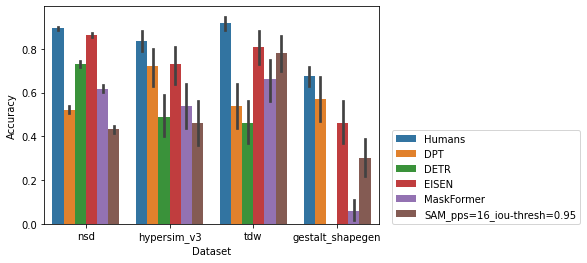

/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ured

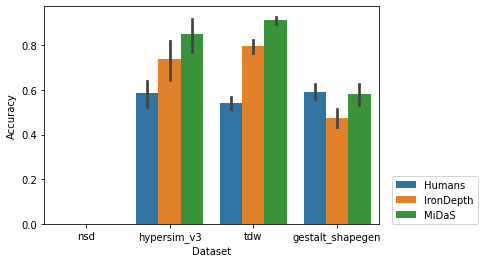

/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


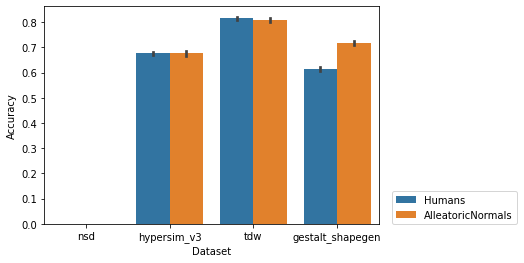

In [975]:
for task in tasks:
    df = pd.read_csv(f"model_results/{task}_human_model_comparison.csv")
    sns.barplot(x="Dataset", y="Accuracy", hue="Model", data=df)
    plt.legend(loc=(1.04, 0))
    plt.show()

In [976]:
palette = "Spectral"
models = ["Humans", "EISEN", "DPT", "DETR", "MaskFormer", "Segment Anything", "IronDepth", "MiDaS", "AlleatoricNormals"]
colors = ["#ffadad","#ffd6a5","#fdffb6","#caffbf","#9bf6ff","#a0c4ff","#bdb2ff","#ffc6ff","#fadffc"]
model_colors = {model: colors[i] for i, model in enumerate(models)}

split_half_corrs = {
    "segmentation": {"tdw": 1, "gestalt_shapegen": 0.96, "hypersim_v3": 0.99, "nsd": 0.99},
    "depth": {"tdw": 0.96, "gestalt_shapegen": 0.79, "hypersim_v3": 0.94, "nsd": 0.98},
    "surface-normals": {"tdw": 0.88, "gestalt_shapegen": 0.56, "hypersim_v3": 0.89, "nsd": 0.87}
}

split_half_cos_sims = {
    "segmentation": {"tdw": 1, "gestalt_shapegen": 0.99, "hypersim_v3": 1, "nsd": 1},
    "depth": {"tdw": 0.99, "gestalt_shapegen": 0.99, "hypersim_v3": 0.99, "nsd": 0.99},
    "surface-normals": {"tdw": 0.96, "gestalt_shapegen": 0.87, "hypersim_v3": 0.95, "nsd": 0.93}
}

segmentation


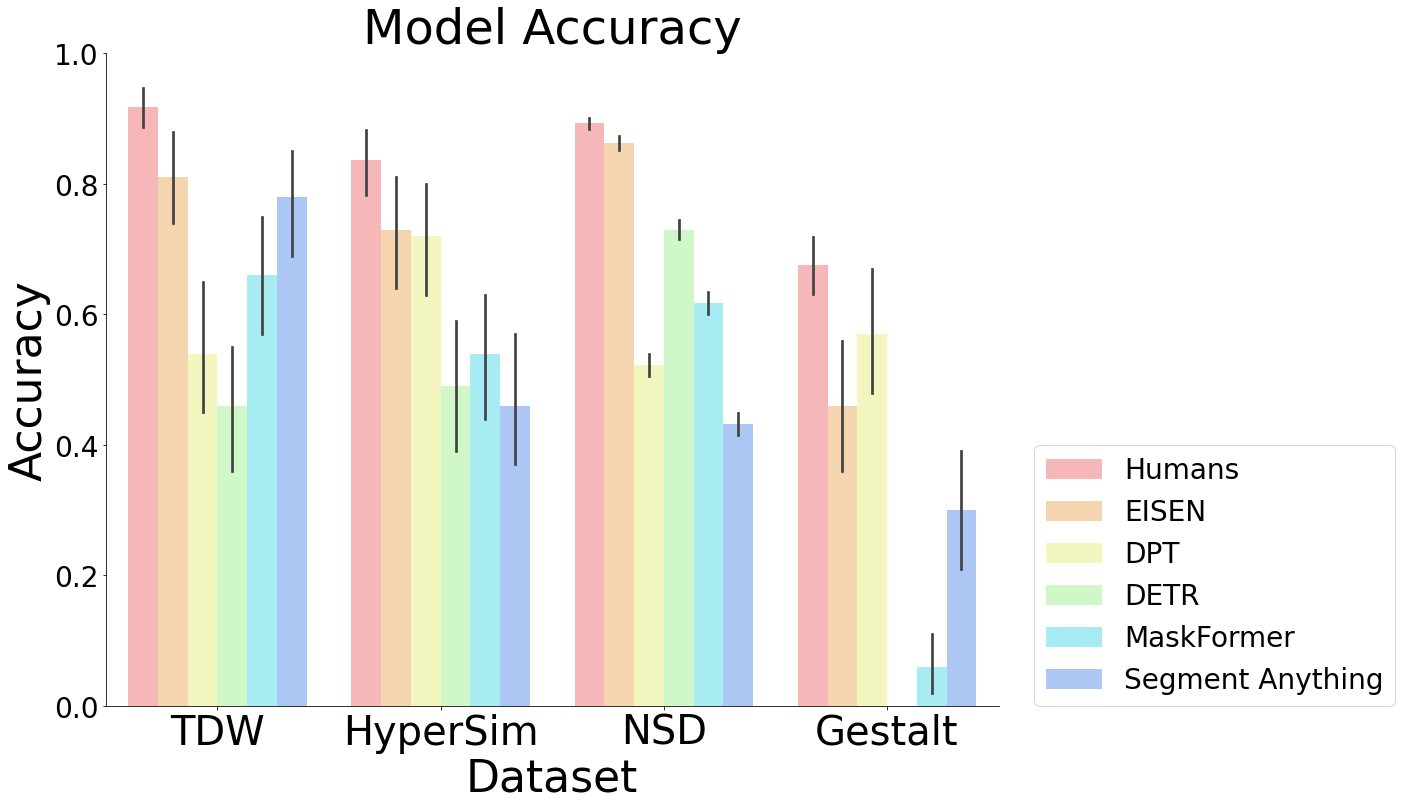

depth


/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ured

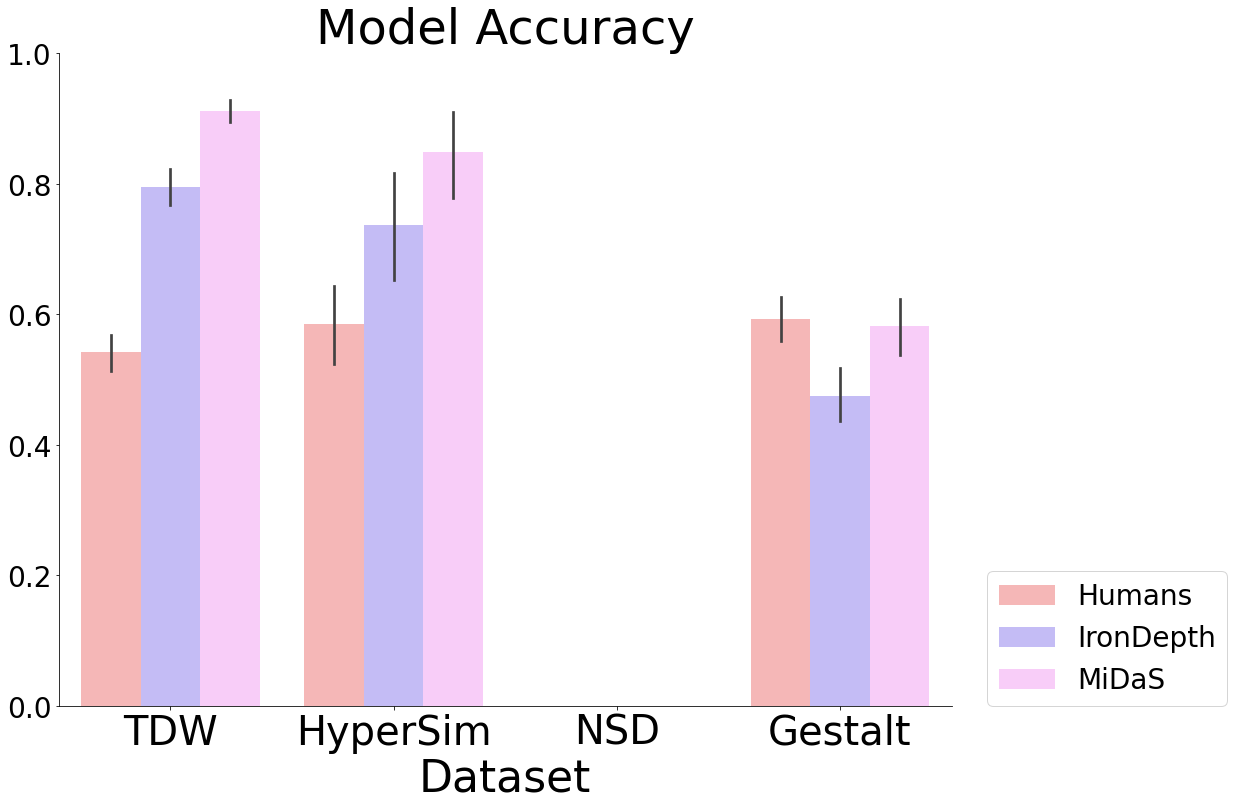

surface-normals


/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


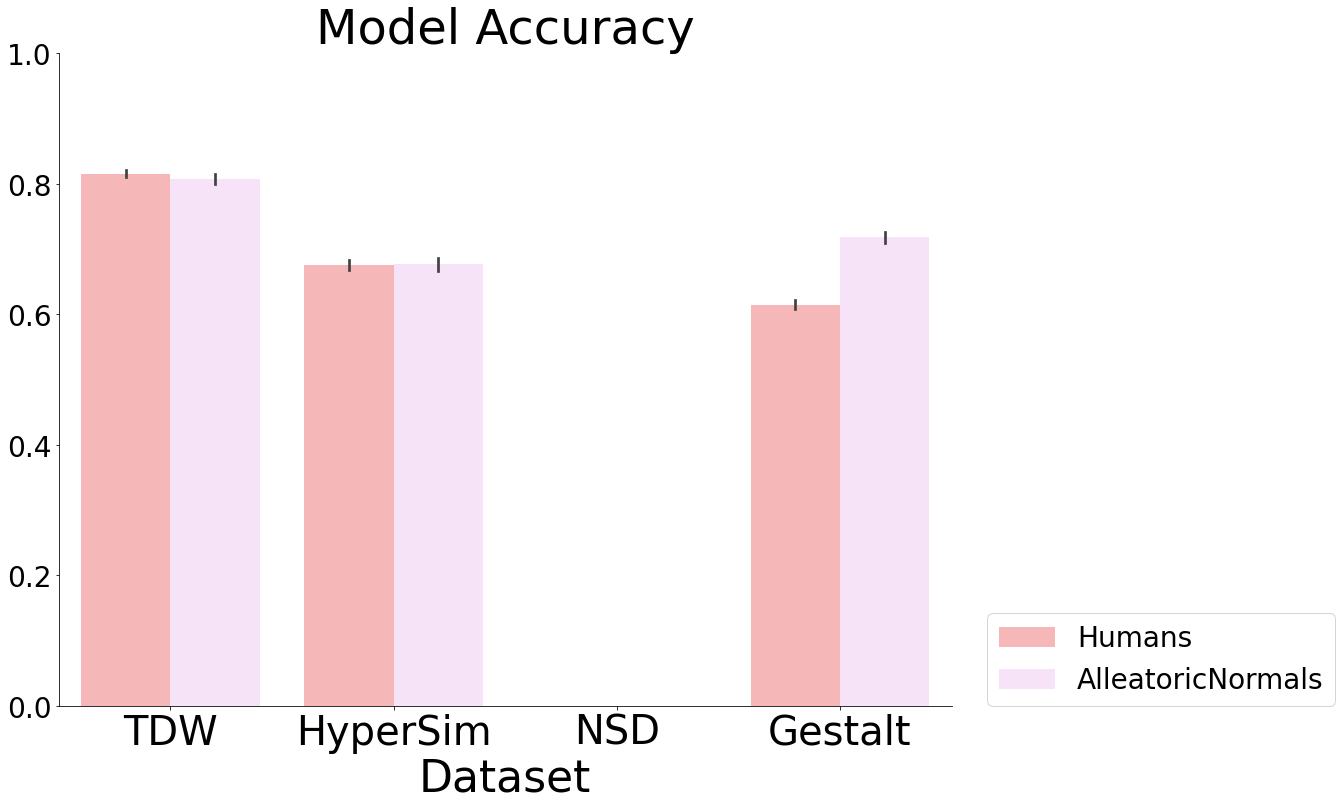

In [977]:
# Plot summary stats
for task in tasks:
    print(task)
    task_df = pd.read_csv(f"model_results/{task}_human_model_comparison.csv")
    if task == "segmentation":
        task_df["Model"] = task_df["Model"].apply(lambda x: "Segment Anything" if x == "SAM_pps=16_iou-thresh=0.95" else x)
        
    fig = plt.figure(figsize=(16, 12))
    ax = plt.subplot(111)

    models = task_df["Model"].unique()
    hue_order = [m for m in model_colors.keys() if m in models]    
    
    sns.barplot(x="Dataset", y="Accuracy", hue="Model", data=task_df, palette=model_colors, hue_order=hue_order, order=["tdw", "hypersim_v3", "nsd", "gestalt_shapegen"], ax=ax)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.legend(loc=(1.04, 0), fontsize=28)
    #ax.get_legend().remove()
    plt.title(f"Model Accuracy", fontsize=48)
    plt.xticks(range(4), ["TDW", "HyperSim", "NSD", "Gestalt"], fontsize=40)
    plt.yticks(fontsize=28)
    plt.xlabel("Dataset", fontsize=44)
    if task == "segmentation":
        plt.ylabel("Accuracy", fontsize=44)
    else:
        ax.set_ylabel("")

    plt.ylim(0, 1)
    plt.show()

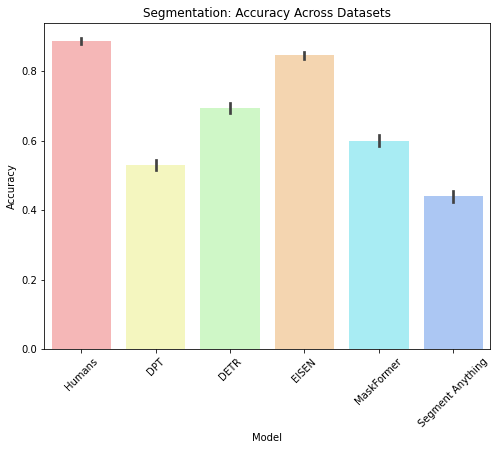

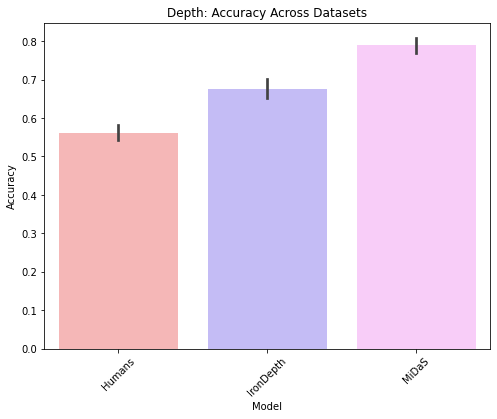

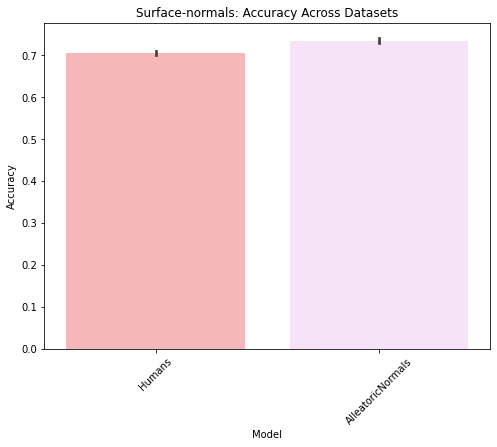

In [978]:
for task in tasks:
    task_df = pd.read_csv(f"model_results/{task}_human_model_comparison.csv")
    if task == "segmentation":
        task_df["Model"] = task_df["Model"].apply(lambda x: "Segment Anything" if x == "SAM_pps=16_iou-thresh=0.95" else x)
        
    # Plot summary stats
    fig = plt.figure(figsize=(8, 6))

    sns.barplot(x="Model", y="Accuracy", data=task_df, palette=model_colors)
    plt.xticks(rotation=45)
    plt.title(f"{task.capitalize()}: Accuracy Across Datasets")
    plt.show()

In [ ]:
def compute_split_half(task_df):
    human_data = task_df[task_df["Model"] == "Humans"]
    split_halves = []
    split_half_sbs = []

    for i in range(1000):
        
    

def compute_surface_normal_split_half():
    pass

def compute_accuracy():
    pass

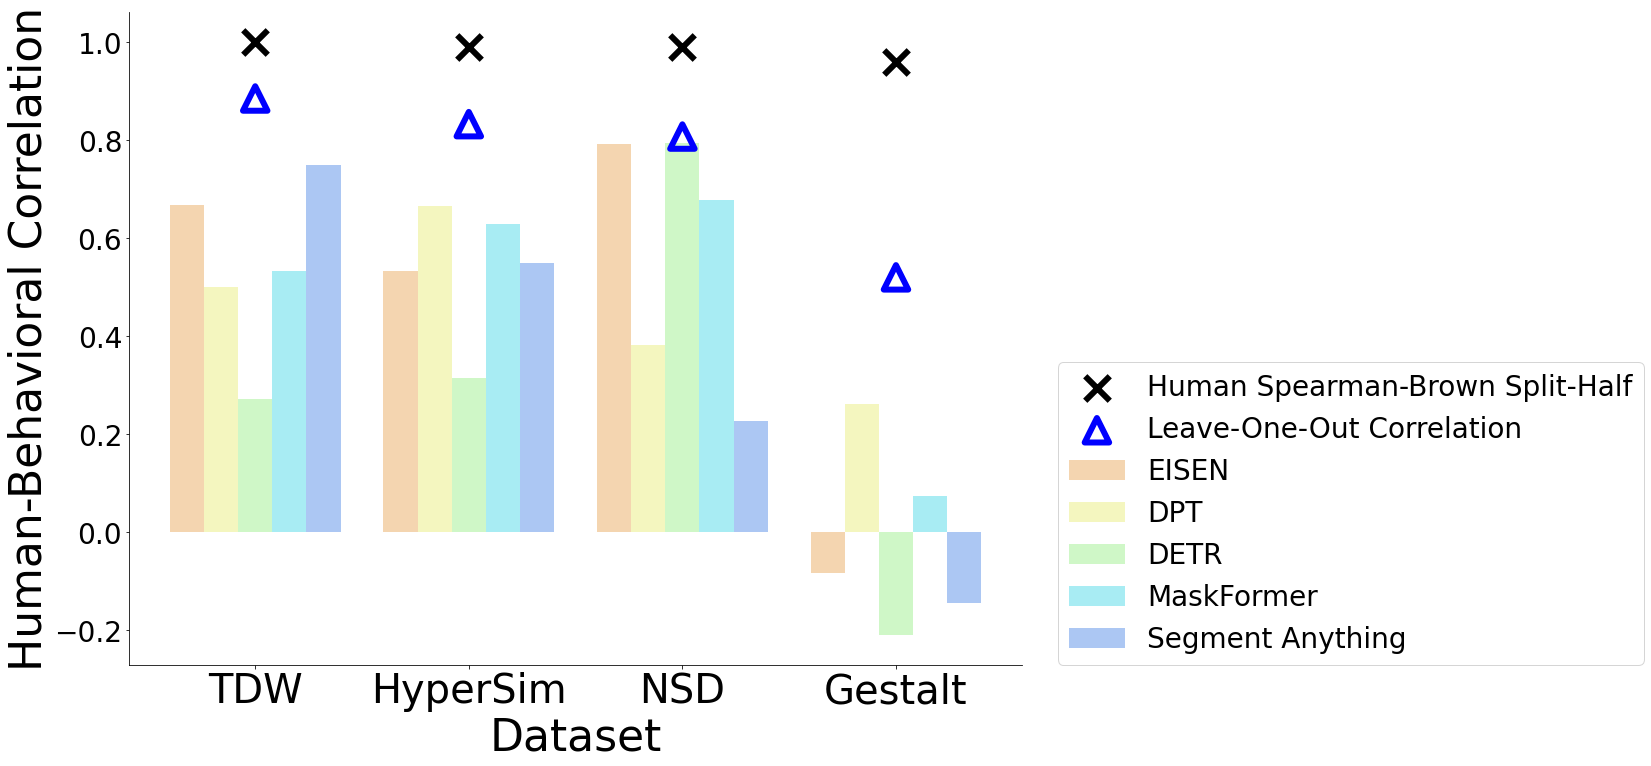

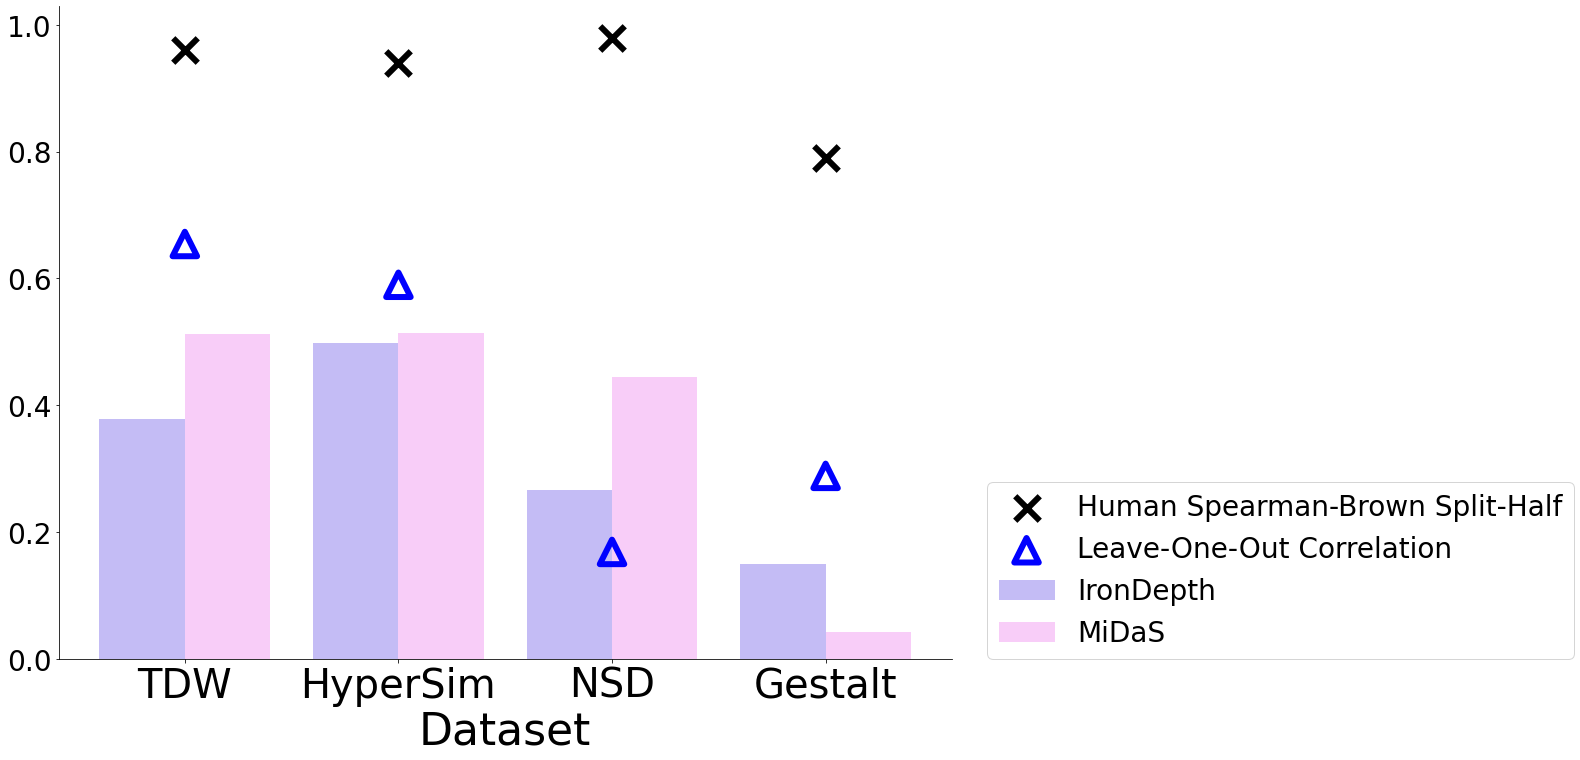

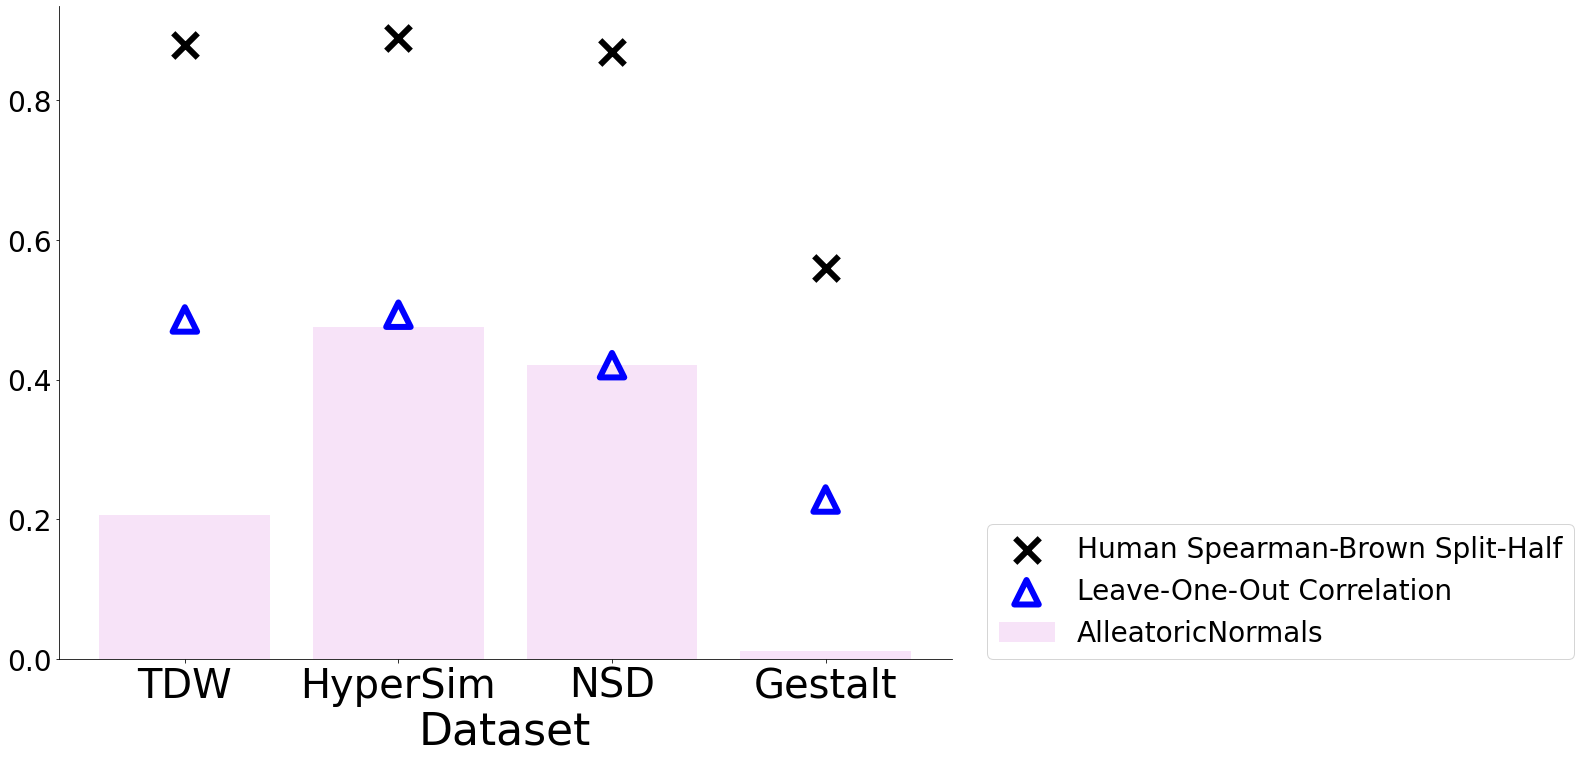

In [979]:
# Compute human-response similarity
# Groupby dataset, batchID, task and get average response from humans and models for each trial

for task in tasks:
    task_df = pd.read_csv(f"model_results/{task}_human_model_comparison.csv")
    if task == "segmentation":
        task_df["Model"] = task_df["Model"].apply(lambda x: "Segment Anything" if x == "SAM_pps=16_iou-thresh=0.95" else x)

    if task == "surface-normals":
        task_df["Response"] = task_df["Response"].apply(lambda x: [float(y) for y in x.strip("[]").split(" ") if y])

    human_resps = {}
    model_resps = {}
    human_model_corrs = []
    models = task_df["Model"].unique()
    for dataset, batches in task_df.groupby("Dataset"):
        human_resps = np.array([np.array(x) for x in batches[batches["Model"] == "Humans"]["Response"]])
        for model in models:
            model_resps = [np.array(x) for x in batches[batches["Model"] == model]["Response"]]
            model_resps = np.array(model_resps)

            if task == "surface-normals":
                dim_corrs = []
                for i in range(3):
                    dim_corr = np.corrcoef(human_resps[:, i], model_resps[:, i])[0, 1]
                    dim_corrs.append(dim_corr)
                corr = np.mean(dim_corrs)
            else:
                corr = np.ma.corrcoef(np.ma.masked_invalid(human_resps), np.ma.masked_invalid(model_resps))[0, 1]

            human_model_corrs.append({"Dataset": dataset, "Model": model, "Human-Behavioral Correlation": corr})

    corr_df = pd.DataFrame(human_model_corrs)        
    fig = plt.figure(figsize=(16, 12))
    ax = plt.subplot(111)
    datasets = ["tdw", "hypersim_v3", "nsd", "gestalt_shapegen"]
    hue_order = [m for m in model_colors.keys() if m in models if m != "Humans"]   
    sns.barplot(x="Dataset", y="Human-Behavioral Correlation", hue="Model", order=datasets, hue_order=hue_order, palette=model_colors, data=corr_df)
    for i, dataset in enumerate(datasets):
        split_half_corr = np.mean(split_half_corrs[task][dataset])
        loo_corr = np.mean(loo_correlations[task][dataset])
        plt.scatter(i, split_half_corr, color="black", marker="x", s=600, linewidths=6, label="Human Spearman-Brown Split-Half")
        plt.scatter(i, loo_corr, color="blue", marker="^", facecolors='none', linewidth=6, s=600, label="Leave-One-Out Correlation")

    handles, labels = plt.gca().get_legend_handles_labels()
    
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc=(1.04, 0), fontsize=28)
    #plt.legend().remove()
    # plt.ylim(0, 1.025)
    plt.xticks(range(4), ["TDW", "HyperSim", "NSD", "Gestalt"], fontsize=40)
    plt.xlabel("Dataset", fontsize=44)
    if task == "segmentation":
        plt.ylabel("Human-Behavioral Correlation", fontsize=44)
    else:
        ax.set_ylabel("")
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.yticks(fontsize=28)

    plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Dataset                       44 non-null     object 
 1   Model                         44 non-null     object 
 2   Human-Behavioral Correlation  44 non-null     float64
 3   Task                          44 non-null     object 
dtypes: float64(1), object(3)
memory usage: 1.5+ KB
None


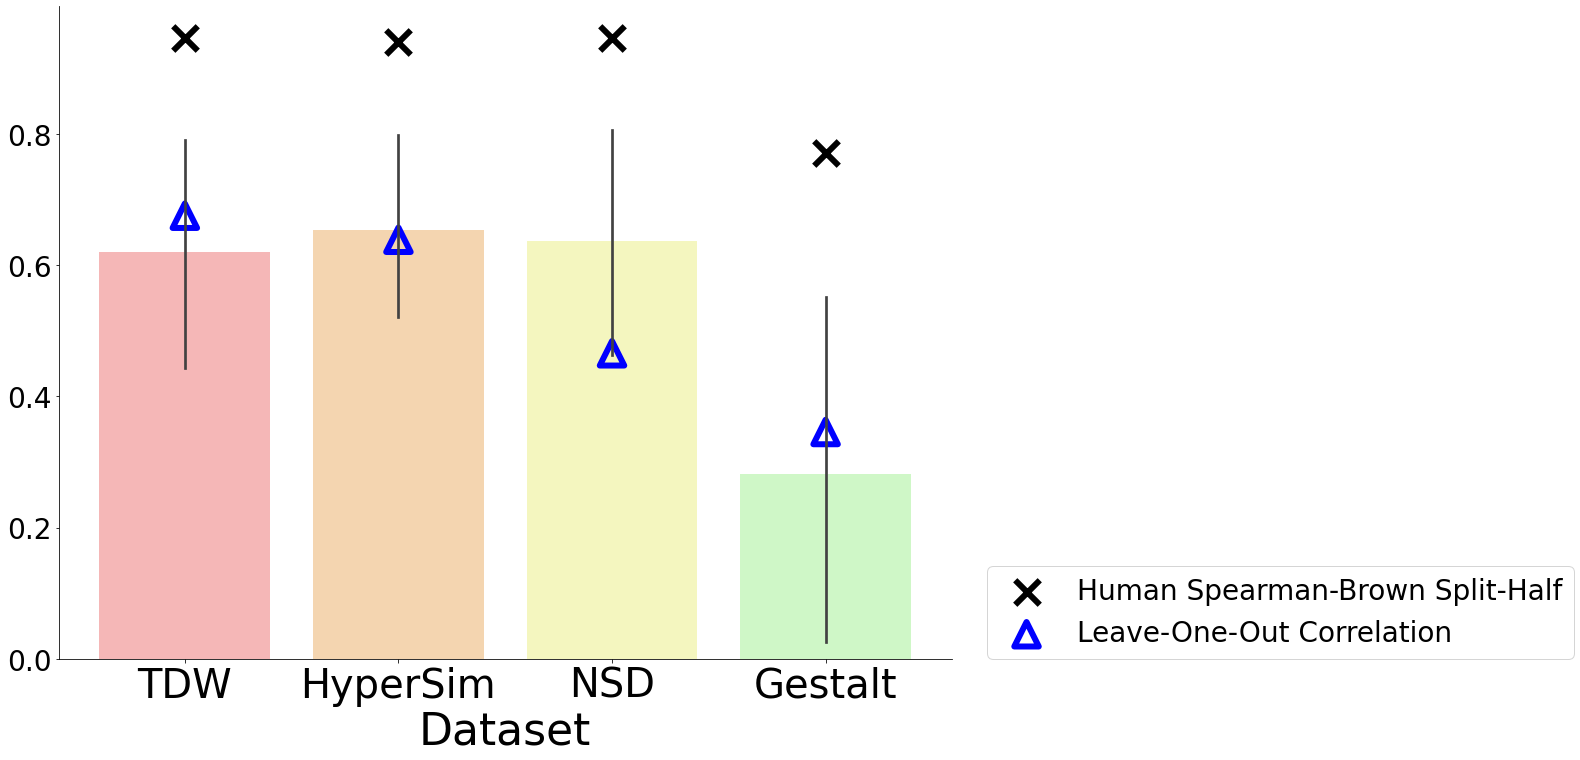

In [980]:
# Compute human-response similarity
# Groupby dataset, batchID, task and get average response from humans and models for each trial

all_corrs_df = []
for task in tasks:
    task_df = pd.read_csv(f"model_results/{task}_human_model_comparison.csv")
    if task == "segmentation":
        task_df["Model"] = task_df["Model"].apply(lambda x: "Segment Anything" if x == "SAM_pps=16_iou-thresh=0.95" else x)

    if task == "surface-normals":
        task_df["Response"] = task_df["Response"].apply(lambda x: [float(y) for y in x.strip("[]").split(" ") if y])

    human_resps = {}
    model_resps = {}
    models = task_df["Model"].unique()
    for dataset, batches in task_df.groupby("Dataset"):
        human_resps = np.array([np.array(x) for x in batches[batches["Model"] == "Humans"]["Response"]])
        for model in models:
            model_resps = [np.array(x) for x in batches[batches["Model"] == model]["Response"]]
            model_resps = np.array(model_resps)

            if task == "surface-normals":
                dim_corrs = []
                for i in range(3):
                    dim_corr = np.corrcoef(human_resps[:, i], model_resps[:, i])[0, 1]
                    dim_corrs.append(dim_corr)
                corr = np.mean(dim_corrs)
            else:
                corr = np.ma.corrcoef(np.ma.masked_invalid(human_resps), np.ma.masked_invalid(model_resps))[0, 1]

            all_corrs_df.append({"Dataset": dataset, "Model": model, "Human-Behavioral Correlation": corr, "Task": task})

all_corrs_df = pd.DataFrame(all_corrs_df)    
print(all_corrs_df.info())    
fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(111)
datasets = ["tdw", "hypersim_v3", "nsd", "gestalt_shapegen"]
hue_order = [m for m in model_colors.keys() if m in models if m != "Humans"]   

sns.barplot(x="Dataset", y="Human-Behavioral Correlation", order=datasets, palette=colors, data=all_corrs_df)

for i, dataset in enumerate(datasets):
    task_loo_corrs = []
    task_split_halfs = []
    for task in tasks:
        split_half_corr = np.mean(split_half_corrs[task][dataset])
        loo_corr = np.mean(loo_correlations[task][dataset])
        task_split_halfs.append(split_half_corr)
        task_loo_corrs.append(loo_corr)

    split_half_corr = np.mean(task_split_halfs)
    loo_corr = np.mean(task_loo_corrs)
    plt.scatter(i, split_half_corr, color="black", marker="x", s=600, linewidths=6, label="Human Spearman-Brown Split-Half")
    plt.scatter(i, loo_corr, color="blue", marker="^", facecolors='none', linewidth=6, s=600, label="Leave-One-Out Correlation")

handles, labels = plt.gca().get_legend_handles_labels()

by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(1.04, 0), fontsize=28)
#plt.legend().remove()
# plt.ylim(0, 1.025)
plt.xticks(range(4), ["TDW", "HyperSim", "NSD", "Gestalt"], fontsize=40)
plt.xlabel("Dataset", fontsize=44)
if task == "segmentation":
    plt.ylabel("Human-Behavioral Correlation", fontsize=44)
else:
    ax.set_ylabel("")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.yticks(fontsize=28)

plt.show()

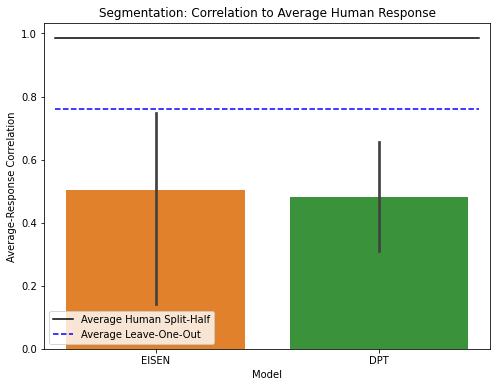

In [48]:
fig = plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y="Average-Response Correlation", palette=model_colors, data=df[df["Model"] != "Humans"])
datasets = ["tdw", "hypersim_v3", "nsd", "gestalt_shapegen"]
avg_split_half = 0
avg_loo = 0
for i, dataset in enumerate(datasets):
    split_half_corr = split_half_corrs[task][dataset]
    avg_split_half += split_half_corr

    loo_corr = loo_correlations[task][dataset]
    avg_loo += loo_corr

avg_loo /= len(datasets)
avg_split_half /= len(datasets)

plt.axhline(np.mean(avg_split_half), xmin=0.025, xmax=.975,  color="black", label="Average Human Split-Half")
plt.axhline(np.mean(avg_loo), xmin=0.025, xmax=.975,  color="blue", linestyle="--", label="Average Leave-One-Out")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title(f"{task.capitalize()}: Correlation to Average Human Response")
plt.show()

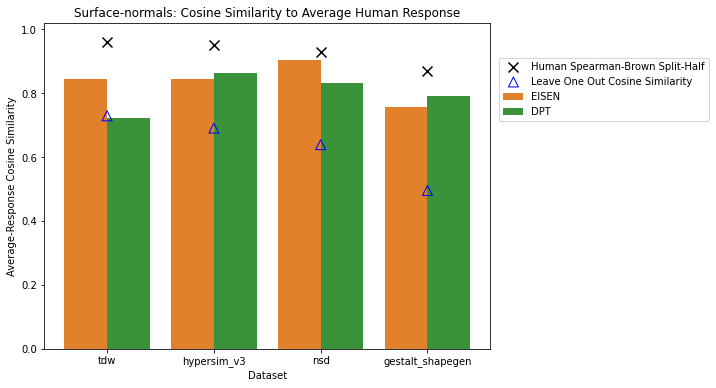

In [53]:
fig = plt.figure(figsize=(8, 6))
sns.barplot(x="Dataset", y="Average-Response Cosine Similarity", hue="Model", palette=model_colors, data=df[df["Model"] != "Humans"])
datasets = ["tdw", "hypersim_v3", "nsd", "gestalt_shapegen"]
for i, dataset in enumerate(datasets):
    split_half_cos_sim = split_half_cos_sims[task][dataset]
    loo_cos_sim = loo_cos_sims[task][dataset]
    plt.scatter(i, np.mean(split_half_cos_sim), color="black", marker="x", s=100, label="Human Spearman-Brown Split-Half")
    plt.scatter(i, np.mean(loo_cos_sim), color="blue", marker="^", facecolors='none', s=100, label="Leave One Out Cosine Similarity")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(1.02, 0.7))

plt.ylim(0, 1.02)
plt.title(f"{task.capitalize()}: Cosine Similarity to Average Human Response")
plt.show()

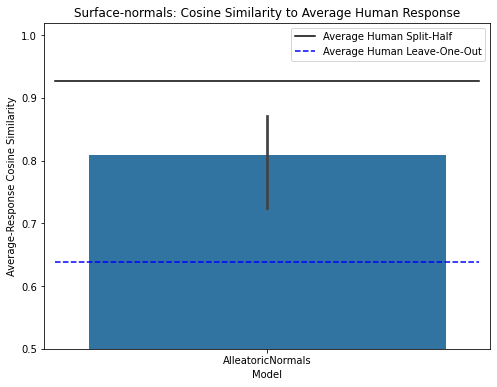

In [161]:
fig = plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y="Average-Response Cosine Similarity",palette=model_colors, data=df[df["Model"] != "Humans"])
datasets = ["tdw", "hypersim_v3", "nsd", "gestalt_shapegen"]

avg_split_half = 0
avg_loo_cos = 0
for i, dataset in enumerate(datasets):
    split_half_cos = split_half_cos_sims[task][dataset]
    avg_split_half += split_half_cos

    loo_cos = loo_cos_sims[task][dataset]
    avg_loo_cos += loo_cos

avg_loo_cos /= len(datasets)
avg_split_half /= len(datasets)

plt.axhline(np.mean(avg_split_half), xmin=0.025, xmax=.975,  color="black", label="Average Human Split-Half")
plt.axhline(np.mean(avg_loo_cos), xmin=0.025, xmax=.975,  color="blue", linestyle="--", label="Average Human Leave-One-Out")
plt.ylim(0.5, 1.02)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title(f"{task.capitalize()}: Cosine Similarity to Average Human Response")
plt.show()

In [1004]:
import einops
import torch
%load_ext autoreload
%autoreload 2
import colormap
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


MaskFormer
(512, 512)
DPT
(512, 512, 3)
SAM_pps=16_iou-thresh=0.95
(512, 512, 3)
EISEN
(512, 512, 3)
DETR
(512, 512, 3)


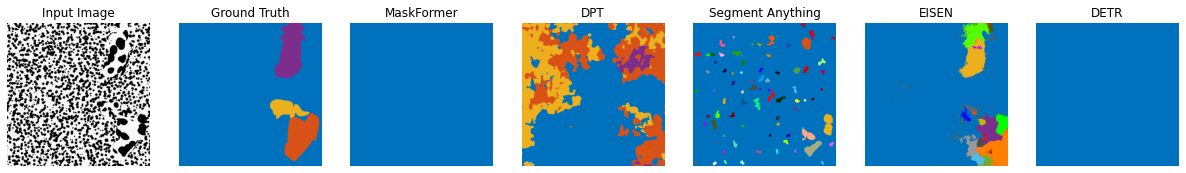

MaskFormer
(425, 425)
DPT
(512, 512, 3)
SAM_pps=16_iou-thresh=0.95
(512, 512, 3)
EISEN
(512, 512, 3)
DETR
(512, 512, 3)


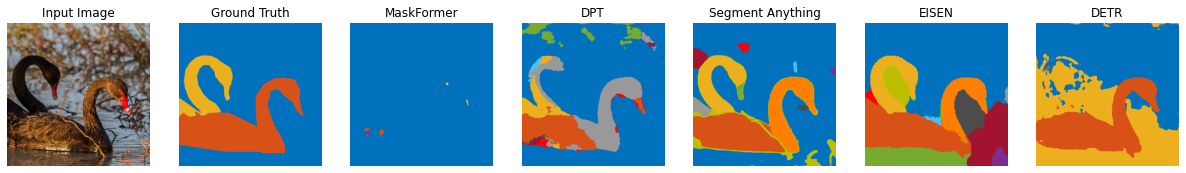

In [1077]:
def compare_model_predictions(dataset, task, image_id):
    img = (get_input_img(task, dataset, image_id) / 255).astype(np.float32)
    gt = get_ground_truth(task, dataset, image_id)
    if gt is not None and gt.max() > 1:
        gt = (gt / gt.max()).astype(np.float32)
    if task == "surface-normals":
        if gt is not None:
            gt = gt.astype(np.float32)
            
        models = [m.split("/")[-1] for m in glob(f"model_predictions/normals/*")]
    else:
        models = [m.split("/")[-1] for m in glob(f"model_predictions/{task}/*")]
    
    extra_cols = 2 if type(gt) == np.ndarray else 1
    fig, axs = plt.subplots(1, len(models) + extra_cols, figsize=((len(models) + extra_cols) * 3, 4))
    preds = []
    for model in models:
        print(model)
        if task == "segmentation":
            model_pred = load_model_prediction(task, dataset, model, image_id, resize=(512,512))
            model_pred = cv2.resize(model_pred, (512, 512), interpolation=cv2.INTER_NEAREST)
            print(gt.shape)
            gt = cv2.resize(np.array(gt), (512, 512), interpolation=cv2.INTER_NEAREST)
            gt = colormap.remap_labels(gt)

            label_assignment = colormap.hungarian_assigmnent(gt, model_pred)
            model_pred = colormap.remap_labels(model_pred, label_assignment)
            model_pred = colormap.labels_to_rgb(model_pred)
            gt = colormap.labels_to_rgb(gt)
        else:
            model_pred = load_model_prediction(task, dataset, model, image_id)

        # if task == "surface-normals":
        #     model_pred = normal_to_rgb(model_pred)
        #     print(model_pred.shape)
        preds.append(model_pred)
    
    if dataset == "gestalt_shapegen":
        axs[0].imshow(img, cmap="gray")
    else:
        axs[0].imshow(img)
    axs[0].set_title("Input Image")
    axs[0].axis("Off")
    if type(gt) is np.ndarray:
        axs[1].imshow(gt)
        axs[1].set_title("Ground Truth")
        axs[1].axis("off")

    for i, pred in enumerate(preds):
        axs[i + extra_cols].axis("off")
        axs[i + extra_cols].imshow(preds[i])
        if models[i] == "SAM_pps=16_iou-thresh=0.95":
            model_name = "Segment Anything"
        else:
            model_name = models[i]
        axs[i + extra_cols].set_title(model_name)
    
    # plt.suptitle(f"{task.capitalize()} Prediction Comparison for {dataset} Image {image_id}", y=.95)
    plt.savefig(f"/Users/yonifriedman/Desktop/{task}_{dataset}_{image_id}.png", dpi=300)
    plt.show()   

# task = "depth"
# compare_model_predictions("gestalt_shapegen", task, 88)
# compare_model_predictions("hypersim_v3", task, 32)

task = "segmentation"
compare_model_predictions("gestalt_shapegen", task, 11)
compare_model_predictions("nsd", task, 77)


# task = "surface-normals"
# compare_model_predictions("tdw", task, 88)
# compare_model_predictions("hypersim_v3", task, 21)




# task = "depth"
# compare_model_predictions("tdw", task, 5)
# compare_model_predictions("hypersim_v3", task, 5)
# compare_model_predictions("gestalt_shapegen", task, 5)


